<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint machine learning flow

## [Problem 1] Cross Validation

In [ ]:
# !pip install -U scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("sample_data/application_train.csv", index_col='SK_ID_CURR')
df = data.drop("TARGET", axis=1)
df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from sklearn.model_selection import train_test_split

X, y = data.drop('TARGET', axis=1), data['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(230633, 120) (76878, 120) (230633,) (76878,)


### Run baseline model

In [4]:
discrete_cols = df.select_dtypes(include='int').columns.tolist()

# Bring high cordinality columns to numerical pipeline
numerical_cols = df.select_dtypes(include='float').columns.tolist() \
                    + [col for col in discrete_cols if df[col].nunique() >= 30]
low_card_discrete_cols = [col for col in discrete_cols if df[col].nunique() < 30]
categorical_cols = df.select_dtypes(include='object').columns.tolist()

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Column preprocessing
numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                   StandardScaler())
low_card_discrete_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"))
categorical_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                     OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer((numerical_pipeline, numerical_cols),
                                       (SimpleImputer(strategy="most_frequent"), low_card_discrete_cols),
                                       (categorical_pipeline, categorical_cols))

In [6]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(preprocessor, LogisticRegression(C = 0.0001))
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9185722833580479

ROC score: 0.7379661323213398


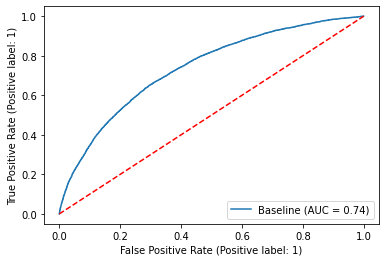

In [7]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

y_score = model.predict_proba(X_val)
score = roc_auc_score(y_val, y_score[:,1])
print("ROC score:", score)
plot_roc_curve(model, X_val, y_val, drop_intermediate=False, name="Baseline")
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.show()

### Use K-Fold to validate

ROC score: 0.7354664416503978


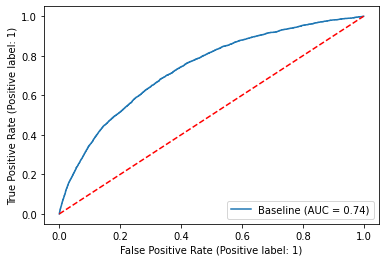

ROC score: 0.7403703350960846


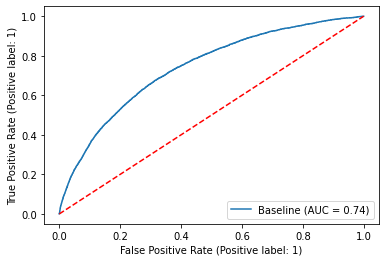

ROC score: 0.7343611659342597


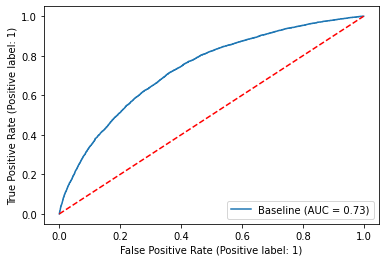

ROC score: 0.7330116036364821


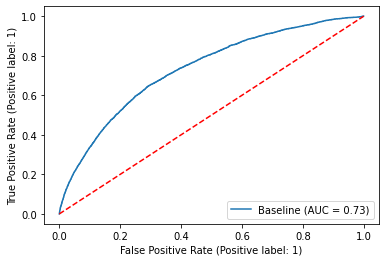

ROC score: 0.7362197584170727


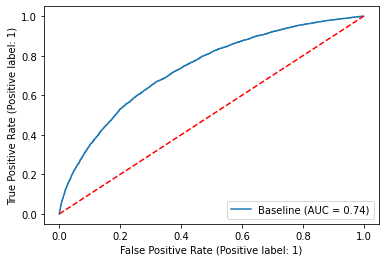

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)

model = make_pipeline(preprocessor, LogisticRegression(C = 0.0001))
for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    model.fit(X_train, y_train)
    model.score(X_val, y_val)

    y_score = model.predict_proba(X_val)
    score = roc_auc_score(y_val, y_score[:,1])
    print("ROC score:", score)
    plot_roc_curve(model, X_val, y_val, drop_intermediate=False, name="Baseline")
    plt.plot([0, 1], [0, 1], linestyle='--', color='r')
    plt.show()

## [Problem 2] Grid search

In [9]:
print(model)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_REGISTRATION',
                                                   'OWN_CAR_AGE',
                                                   'CNT_FAM_MEMBERS',
                             

In [10]:
from sklearn.model_selection import GridSearchCV

model = make_pipeline(preprocessor, LogisticRegression())
params = {'logisticregression__C': [0.0001, 0.0003, 0.001]}

grid = GridSearchCV(estimator=model, param_grid=params, scoring="roc_auc", cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'logisticregression__C': 0.001}


## [Problem 3] Survey from Kaggle Notebooks

1.   The top vote Notebooks: Use polynomial transformation on some columns + domain knowledge for features fed the model. Use Random Forest to discover feature importances.
2.   Many used models (RandomForestClassfier or LightGBM, etc.) to extract important features relating to TARGET: [EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH, DAYS_EMPLOYED, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE, DAYS_REGISTRATION]
3. Use Bayesian optimization to automatically tune hyperparameters of Gradient Boosting Machine model.

## [Problem 4] Creating a model with high generalization performance

### Select important features based on referenced results and tune with GridSearchCV

In [11]:
selected_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_BIRTH", 
                 "DAYS_EMPLOYED", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", 
                 "DAYS_ID_PUBLISH", "DAYS_LAST_PHONE_CHANGE", "DAYS_REGISTRATION"]
                
X, y = data[selected_cols], data['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(230633, 11) (76878, 11) (230633,) (76878,)


In [12]:
# Use Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(SimpleImputer(strategy="most_frequent"),
                      StandardScaler(),
                      RandomForestClassifier(n_estimators=100, random_state=0))
print(model)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])


In [13]:
params = {'randomforestclassifier__n_estimators': [50, 100, 150, 250]}

grid = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

0.7164200810193072
{'randomforestclassifier__n_estimators': 250}


### Automatic model tuning with LightGBM as baseline model

#### Baseline LightGBM to understand hyperparameters

In [25]:
import lightgbm as lgb

# Training set
train_set = lgb.Dataset(X_train, label = y_train, free_raw_data=False)
val_set = lgb.Dataset(X_val, label = y_val, free_raw_data=False)

In [23]:
# Default hyperparamters
model = lgb.LGBMClassifier(random_state=0)
hyperparameters = model.get_params()
print(hyperparameters)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 0, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [24]:
# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=10000, nfold=5, metrics='auc', 
                    early_stopping_rounds=100, verbose_eval=False, seed=0)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

The maximium ROC AUC in cross validation was 0.74378 with std of 0.00451.
The ideal number of iterations was 95.


In [16]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
baseline_auc = roc_auc_score(y_val, y_pred)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.74739 ROC AUC on the test set.


### Bayes Optimization tuning method

##### 1. Objective Function

In [27]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = 5, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

##### 2. Domain space: range of input hyperparameters

In [28]:
from hyperopt import hp

# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

##### 3. Optimization algorithm: Tree Parzer Estimator

In [29]:
from hyperopt import tpe

tpe_algorithm = tpe.suggest

##### 4. Run optimizer and store results

In [ ]:
# Training set
train_set = lgb.Dataset(X_train, label = y_train, free_raw_data=False)
val_set = lgb.Dataset(X_val, label = y_val, free_raw_data=False)

In [30]:
from hyperopt import Trials
from hyperopt import fmin

# Record results
trials = Trials()

global ITERATION
ITERATION = 0

# Run optimization
best = fmin(fn=objective, space=space, algo=tpe_algorithm, trials=trials, max_evals=5)
print("Best parameters:")
print(best)

trials_dict = sorted(trials.results, key=lambda x: x['loss'])

100%|██████████| 5/5 [01:21<00:00, 16.26s/it, best loss: 0.25626614303930473]
Best parameters:
{'boosting_type': 0, 'colsample_by_tree': 0.784412944285295, 'gdbt_subsample': 0.684117327613527, 'is_unbalance': 0, 'learning_rate': 0.19578329781476783, 'min_child_samples': 400.0, 'num_leaves': 35.0, 'reg_alpha': 0.3203738316299357, 'reg_lambda': 0.9569229543216434, 'subsample_for_bin': 180000.0}


Summary results

In [31]:
def evaluate(trials):
    scores = [1 - trial['loss'] for trial in trials]
    hyp_df = pd.DataFrame({"SCORE": scores})

    for key in trials[0].keys():
        if key in ["hyperparameters", "loss"]:
            continue
        hyp_df[key] = [trial[key] for trial in trials]

    hyps = [trial['hyperparameters'] for trial in trials]
    for param in hyps[0].keys():
        hyp_df[param] = [hyp[param] for hyp in hyps]
    return hyp_df

In [32]:
results = evaluate(trials_dict)
display(results)

,SCORE,iteration,train_time,status,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,n_estimators
0,0.743734,1,12.037226,ok,gbdt,0.784413,True,0.195783,400,35,0.320374,0.956923,180000,0.684117,36
1,0.740350,4,15.786562,ok,gbdt,0.661446,True,0.247587,470,103,0.479847,0.999245,40000,0.557398,14
2,0.734038,5,13.676554,ok,gbdt,0.997184,True,0.346341,85,129,0.037627,0.319687,200000,0.828335,9
3,0.732881,2,20.514748,ok,goss,0.946716,False,0.055685,465,88,0.585253,0.275456,260000,1.000000,17
4,0.730868,3,19.231817,ok,goss,0.928569,True,0.079712,160,79,0.884549,0.108501,240000,1.000000,12


## [Problem 5] Final model selection
[My Kaggle notebook!!!](https://www.kaggle.com/thanhnguyen2612/ml-sprint1)

Use these hyperparameters for submitted LightGBM model.


*   Score in train data: 0.743734
*   Submission score: 0.66682



In [37]:
print("Best hyperparameters:")
display(trials_dict[0])

Best hyperparameters:


{'hyperparameters': {'boosting_type': 'gbdt',
  'colsample_bytree': 0.784412944285295,
  'is_unbalance': True,
  'learning_rate': 0.19578329781476783,
  'min_child_samples': 400,
  'n_estimators': 36,
  'num_leaves': 35,
  'reg_alpha': 0.3203738316299357,
  'reg_lambda': 0.9569229543216434,
  'subsample': 0.684117327613527,
  'subsample_for_bin': 180000},
 'iteration': 1,
 'loss': 0.25626614303930473,
 'status': 'ok',
 'train_time': 12.037225585001579}